In [1]:
from datetime import date
from glob import glob
import os, sys
from os.path import join, dirname
import pickle
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import nilearn.image, nilearn.masking
from nilearn import plotting as nplt
import statsmodels.stats.multitest

In [2]:
# To make plots using Matplotlib, you must first enable IPython's matplotlib mode.
# To do this, run the %matplotlib magic command to enable plotting in the current Notebook.
# This magic takes an optional argument that specifies which Matplotlib backend should be used. 
# Most of the time, in the Notebook, you will want to use the inline backend,
# which will embed plots inside the Notebook:
%matplotlib inline

In [3]:
sigma_1 = 0.682689492137
sigma_2 = 0.954499736104
sigma_3 = 0.997300203937
today = date.today().strftime("%Y%m%d")

In [4]:
root_dir = '/Volumes/T7SSD1/GL'
script_dir = '.'
fmri_dir = root_dir + '/fMRI_data'
preproc_dir = fmri_dir + '/preproc_data'
data_dir = fmri_dir + '/stats/Reg1_GLM_feedback/group'
roi_dir = root_dir + '/roi'

output_dir = script_dir

In [5]:
temp = glob(join(preproc_dir,'GL*'))
subj_list = [a[-4:] for a in temp]
print(subj_list,'\n',len(subj_list))
# subj_list = ['03','04','05','06','07',
#              '08','09','10','11','12',
#              '14','15','16','17','18',
#              '19','20','21','22','24',
#              '25','26','27','29']

['GL03', 'GL04', 'GL05', 'GL06', 'GL07', 'GL08', 'GL09', 'GL10', 'GL11', 'GL12', 'GL14', 'GL15', 'GL16', 'GL17', 'GL18', 'GL19', 'GL20', 'GL21', 'GL22', 'GL24', 'GL25', 'GL26', 'GL27', 'GL29'] 
 24


In [49]:
roi_list = ('M1','S1')
radius = 3

In [7]:
def fast_masking(epi, roi):
    ## Survives only the value in the ROI and reduces the useless dimensions.
    ## input : 5D epi, 3D roi
    ## output : 2D epi
    if epi.shape[:3] != roi.shape:
        raise ValueError('different xyz shape while masking! epi=%s and roi=%s' % (epi.shape[:3],roi.shape))
    fdata_epi = epi.get_fdata()
    fdata_roi = roi.get_fdata().astype(bool)
    
    temp = fdata_epi[fdata_roi,:]
    
    nvolume = temp.shape[0]
    nval = temp.shape[-2]*temp.shape[-1]

    return temp.reshape(nvolume,nval)

In [8]:
def write_data_nifti(data, mask_img, fname):
    if len(mask_img.shape)!=3:
        raise ValueError('mask image should be in 3D format')
    mask_img_asarray = mask_img.get_fdata()
    template = np.zeros_like(mask_img_asarray)
    template[np.where(mask_img_asarray==1)]=data
    img_write = nib.Nifti1Image(template, mask_img.affine)
    img_write.to_filename(fname)

In [9]:
def accuracy(train_X, train_y, test_X, test_y):
    lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
    lda.fit(train_X, train_y)
    
    return np.mean(lda.predict(test_X) == test_y)

def cross_validation(datasets, target):
    train_y = target + target
    test_y = target
    
    result = []
    
    for i in range(len(datasets)):
        train_X = np.concatenate([a for j, a in enumerate(datasets) if j != i])
        test_X = datasets[i]
        
        result.append(accuracy(train_X, train_y, test_X, test_y))
        
    return np.mean(result)

## Masks

(array([818286,      0,      0, 232338]), array([0.  , 0.25, 0.5 , 0.75, 1.  ]))


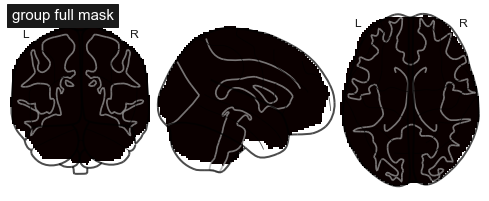

In [75]:
## Full masks of individual subjects (2.000 x 2.000 x 2.000)
path_data = join(roi_dir,'full','full_mask.group.n24.nii.gz')
img_roi = nilearn.image.load_img(path_data)
print(np.histogram(img_roi.get_fdata(), bins=4))
nplt.plot_glass_brain(img_roi, title='group full mask')

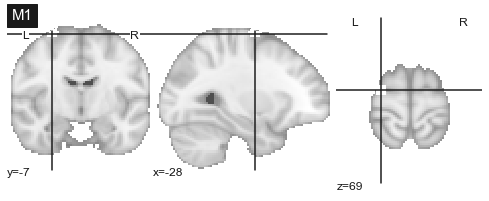

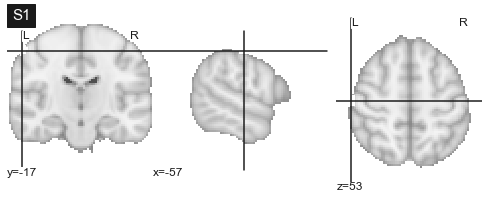

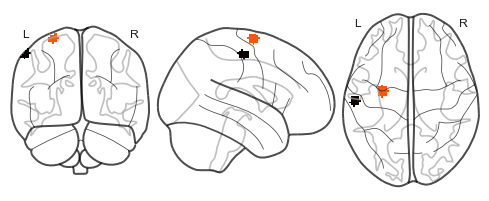

In [76]:
## 3dUndump ROIs from group data
for nn, roi in enumerate(roi_list):
    path_roi = join(roi_dir,'3dUndump.%s.group.rd6.nii.gz'%roi)
    img_roi = nilearn.image.load_img(path_roi)
    if nn == 0:
        img_tot = img_roi
    else:
        img_tot = nilearn.image.math_img('img1+%d*img2'%(nn+1),img1=img_tot,img2=img_roi)
#         img_tot = nilearn.image.math_img('img1+img2',img1=img_tot,img2=img_roi)
    nplt.plot_stat_map(img_roi, vmax=1.0, title='%s'%roi, colorbar=False)
nplt.plot_glass_brain(img_tot)

# GLM results

In [13]:
print(subj_list,':',len(subj_list))
subj = 'GL04'

['GL03', 'GL04', 'GL05', 'GL06', 'GL07', 'GL08', 'GL09', 'GL10', 'GL11', 'GL12', 'GL14', 'GL15', 'GL16', 'GL17', 'GL18', 'GL19', 'GL20', 'GL21', 'GL22', 'GL24', 'GL25', 'GL26', 'GL27', 'GL29'] : 24


In [14]:
# path_epi = join(stat_dir,'Reg1_GLM_feedback','group','stats.group.n24.nii.gz')
# img_epi = nilearn.image.load_img(path_epi)

## FB vs. nFB

epi.shape : (96, 114, 96)


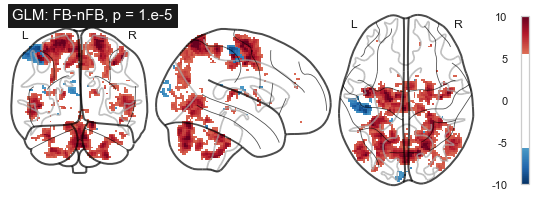

In [81]:
## epi image (2.000 x 2.000 x 2.000)
# ============================================================================
## extract data of interest
nn = 1   # sub-brick #1 'SetA-SetB_Tstat'
path_epi = join(data_dir,'stats.group.n24.nii.gz[%d]'%nn)
pname = join(data_dir,'temp')
if not os.path.isfile(pname+'.nii.gz'):
    os.system("3dcalc -a %s -expr 'a' -prefix %s"%(path_epi,pname))
    os.system("3dAFNItoNIFTI -prefix %s.nii.gz %s+tlrc"%(pname,pname))
    os.system("rm %s+tlrc.*"%pname)
# ============================================================================
## load the temporal dataset
img_epi = nilearn.image.load_img(pname+'.nii.gz')
print('epi.shape :',img_epi.shape)
# ============================================================================
# thsh = 3.7676 # threshold at p = 1.e-3
thsh = 5.6265 # threshold at p = 1.e-5
nplt.plot_glass_brain(img_epi, vmax=10.0, plot_abs=False, cmap='RdBu_r', colorbar=True, threshold=thsh, title='GLM: FB-nFB, p = 1.e-5')
if os.path.isfile(pname+'.nii.gz'):
    os.system("rm %s.nii.gz"%pname)


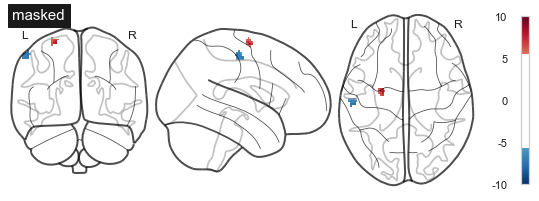

In [82]:
img_masked = nilearn.image.math_img(img1=img_tot, img2=img_epi, formula='(img1 > 0) * img2')
nplt.plot_glass_brain(img_masked, vmax=10.0, plot_abs=False, cmap='RdBu_r', colorbar=True, threshold=thsh, title='masked')

In [16]:
# subj = 'GL03'
# roi = 'M1'

# path_roi = join(roi_dir,'3dUndump.%s.group.rd6.nii.gz'%roi)
# img_roi = nilearn.image.load_img(path_roi)

# nn = 1    # At sub-brick #1 'FB#0_Coef' datum type is float: -19.5535 to 20.5078
# path_epi = join(data_dir,'stats.%s.nii.gz'%subj)
# img_epi = nilearn.image.load_img(path_epi)
# temp = fast_masking(epi=img_epi, roi=img_roi)
# np.mean(temp[:,1])

In [50]:
df = pd.DataFrame(columns=['subj','mean','roi','feed'])
for roi in roi_list:
    ## roi
    path_roi = join(roi_dir,'3dUndump.%s.group.rd%d.nii.gz'%(roi,radius))
    img_roi = nilearn.image.load_img(path_roi)
    for subj in subj_list:
        ## epi
        path_epi = join(data_dir,'stats.%s.nii.gz'%subj)
        img_epi = nilearn.image.load_img(path_epi)
        ## masking
        temp = fast_masking(epi=img_epi, roi=img_roi)
        ## feed : FB
        nn = 1    # At sub-brick #1 'FB#0_Coef' datum type is float: -19.5535 to 20.5078
        mean = np.mean(temp[:,nn])
        df = df.append({'subj':subj,'mean':mean,'roi':roi,'feed':'FB'}, ignore_index=True)
        ## feed : nFB
        nn = 4    # At sub-brick #4 'nFB#0_Coef' datum type is float: -14.7624 to 17.1531
        mean = np.mean(temp[:,nn])
        df = df.append({'subj':subj,'mean':mean,'roi':roi,'feed':'nFB'}, ignore_index=True)
df

,subj,mean,roi,feed
0,GL03,1.436451,M1,FB
1,GL03,1.009037,M1,nFB
2,GL04,0.379144,M1,FB
3,GL04,0.192779,M1,nFB
4,GL05,1.153934,M1,FB
...,...,...,...,...
91,GL26,4.588650,S1,nFB
92,GL27,0.305043,S1,FB
93,GL27,1.307502,S1,nFB
94,GL29,0.600861,S1,FB


## t-test

In [53]:
## t : 'True' if a hypothesis is rejected, 'False' if not
## uncorredted_p : pvalues adjusted for multiple hypothesis testing to limit FDR

pvals, tvals = [], []

for roi in roi_list:
    sub_df = df[df['roi'] == roi]
    
    FB_mean_accs = sub_df[sub_df['feed'] == 'FB']['mean']
    nFB_mean_accs = sub_df[sub_df['feed'] == 'nFB']['mean']
    
    res = scipy.stats.ttest_rel(FB_mean_accs, nFB_mean_accs)
    pvals.append(res.pvalue)
    tvals.append(res.statistic)

## pvalue correction for false discovery rate
res = statsmodels.stats.multitest.fdrcorrection(pvals)

text = []
text.append(['roi','t','p','tval','uncorrected_p'])
for t, p, roi, uncorrected_p, tval in zip(*res, roi_list, pvals, tvals):
    if uncorrected_p < 0.05:
        print('%21s'%roi, '%s'%t, '%.3f'%p, '%5.2f'%tval, '%.3f'%uncorrected_p)
        text.append(['%s'%roi, '%s'%t, '%.3f'%p, '%5.2f'%tval, '%.3f'%uncorrected_p])

                   M1 True 0.000  6.08 0.000
                   S1 True 0.000 -6.45 0.000


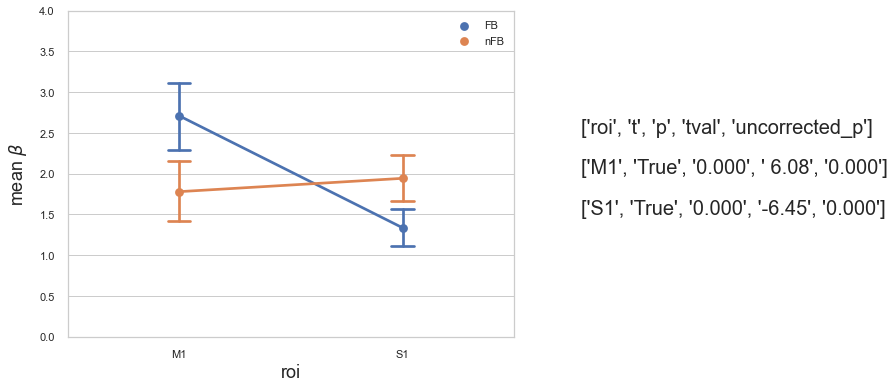

In [52]:
ax = plt.figure(figsize=(8, 6))

plt.style.use('seaborn')

sns.set(style="whitegrid")
sns.pointplot(x='roi', y='mean', data=df,
                   ci=sigma_1*100,      # ci=standard error
                   hue='feed',
                   capsize=.1,
                   markers='o')
plt.ylim(0,4.)
plt.ylabel(r'mean $\beta$', fontsize=18, labelpad=10)
plt.xlabel('roi', size=18)
# plt.title('srad = %d', size=16)   # radius of a roi sphere
plt.legend(loc='best')
plt.text(1.8, 2.5, '%s'%text[0], fontsize=20)
plt.text(1.8, 2.0, '%s'%text[1], fontsize=20)
plt.text(1.8, 1.5, '%s'%text[2], fontsize=20)
ax.savefig(join(output_dir,today+'.mean_beta.group.srad%d.png'%radius), dpi=300)

# GA project

In [13]:
dh = pd.DataFrame(columns=['subj','mean','roi','mapping','group'])
for subj in GA_list:
    ## individual roi mask
    temp = subj[0] + 'A' + subj[2:]
    
    path_roi = join(tt1,'%s_1_caudate_head_resam.nii'%temp)
    roi_head = nilearn.image.load_img(path_roi)
    path_roi = join(tt1,'%s_2_caudate_body_resam.nii'%temp)
    roi_body = nilearn.image.load_img(path_roi)
    path_roi = join(tt1,'%s_3_caudate_tail_resam.nii'%temp)
    roi_tail = nilearn.image.load_img(path_roi)

    ## epi (Run 1 to 3)
#     path_epi = join(tt2,'Reg3_GLM_caudate_Late','group','statsRWDtime.%s.run1to3.SPMG2.nii.gz'%subj)
    path_epi = join('/Volumes/T7SSD1/GA/fMRI_data/stats/fig4/late','statsRWDtime.%s.run1to3.SPMG2.nii.gz'%subj)
    epi = nilearn.image.load_img(path_epi)
    ## caudate head
    roi = roi_head
    size_roi = np.sum(roi_head.get_fdata())
    temp = nilearn.image.math_img("img1*img2", img1=epi, img2=roi)
    mean = np.sum(temp.get_fdata())/size_roi
    dh = dh.append({'subj':subj,'mean':mean,'roi':'head','mapping':'trained','group':'Late'}, ignore_index=True)
    ## caudate body
    roi = roi_body
    size_roi = np.sum(roi_body.get_fdata())
    temp = nilearn.image.math_img("img1*img2", img1=epi, img2=roi)
    mean = np.sum(temp.get_fdata())/size_roi
    dh = dh.append({'subj':subj,'mean':mean,'roi':'body','mapping':'trained','group':'Late'}, ignore_index=True)
    ## caudate tail
    roi = roi_tail
    size_roi = np.sum(roi_tail.get_fdata())
    temp = nilearn.image.math_img("img1*img2", img1=epi, img2=roi)
    mean = np.sum(temp.get_fdata())/size_roi
    dh = dh.append({'subj':subj,'mean':mean,'roi':'tail','mapping':'trained','group':'Late'}, ignore_index=True)
    
    ## epi (Run 4 to 6)
#     path_epi = join(tt2,'Reg3_GLM_caudate_Late','group','statsRWDtime.%s.run4to6.SPMG2.nii.gz'%subj)
    path_epi = join('/Volumes/T7SSD1/GA/fMRI_data/stats/fig4/late','statsRWDtime.%s.run4to6.SPMG2.nii.gz'%subj)
    epi = nilearn.image.load_img(path_epi)
    ## caudate head
    roi = roi_head
    size_roi = np.sum(roi_head.get_fdata())
    temp = nilearn.image.math_img("img1*img2", img1=epi, img2=roi)
    mean = np.sum(temp.get_fdata())/size_roi
    dh = dh.append({'subj':subj,'mean':mean,'roi':'head','mapping':'untrained','group':'Late'}, ignore_index=True)
    ## caudate body
    roi = roi_body
    size_roi = np.sum(roi_body.get_fdata())
    temp = nilearn.image.math_img("img1*img2", img1=epi, img2=roi)
    mean = np.sum(temp.get_fdata())/size_roi
    dh = dh.append({'subj':subj,'mean':mean,'roi':'body','mapping':'untrained','group':'Late'}, ignore_index=True)
    ## caudate tail
    roi = roi_tail
    size_roi = np.sum(roi_tail.get_fdata())
    temp = nilearn.image.math_img("img1*img2", img1=epi, img2=roi)
    mean = np.sum(temp.get_fdata())/size_roi
    dh = dh.append({'subj':subj,'mean':mean,'roi':'tail','mapping':'untrained','group':'Late'}, ignore_index=True)

dh

,subj,mean,roi,mapping,group
0,GA01,0.153668,head,trained,Late
1,GA01,0.268254,body,trained,Late
2,GA01,0.110907,tail,trained,Late
3,GA01,0.044009,head,untrained,Late
4,GA01,-0.110906,body,untrained,Late
...,...,...,...,...,...
175,GA44,0.031869,body,trained,Late
176,GA44,-0.162780,tail,trained,Late
177,GA44,0.210411,head,untrained,Late
178,GA44,0.012130,body,untrained,Late


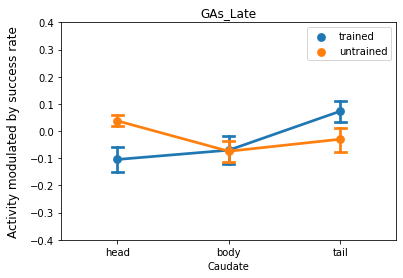

In [14]:
ax = sns.pointplot(x='roi', y='mean', data=dh,
                   ci=sigma_1*100,      # ci=standard error
                   hue='mapping',
                   capsize=.1,
                   markers='o')
ax.set_ylim(-.4,.4)
ax.set_ylabel('Activity modulated by success rate', fontsize=12, labelpad=10)
ax.set_xlabel('Caudate')
ax.set_title('GAs_Late')
ax.legend(loc='best')
# plt.savefig('mean_cadate.png', dpi=300)

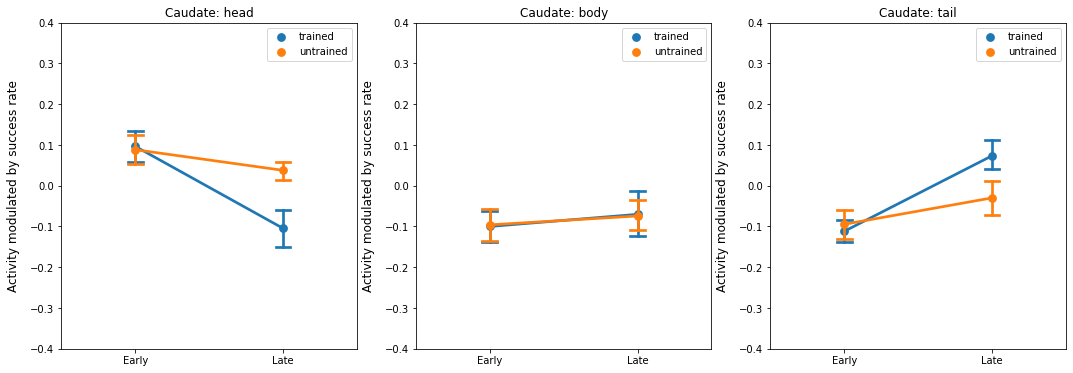

In [116]:
dk = dg.append(dh)

fig, axes = plt.subplots(1,3)
fig.set_size_inches(18, 6)

for i,roi in enumerate(['head','body','tail']):
    ax = sns.pointplot(x='group', y='mean', data=dk[dk.roi==roi],
                       ci=sigma_1*100,      # ci=standard error
                       hue='mapping',
                       capsize=.1,
                       markers='o',
                       ax = axes[i])
    ax.set_ylim(-.4,.4)
    ax.legend(loc='best')
    ax.set_ylabel('Activity modulated by success rate', fontsize=12, labelpad=10)
    ax.set_xlabel(None)
    ax.set_title('Caudate: %s'%roi)
plt.savefig(today+'_replicate_fig4', dpi=300)

## Plot the data for 12 people in group GD

In [19]:
df = pd.DataFrame(columns=['subj','mean','roi','mapping','group'])
for subj in subj_list:
    ## individual roi mask
    temp = subj[0] + 'A' + subj[2:]
    path_roi = join(mask_caudate_fin_dir,'%s_1_caudate_head_resam.nii'%temp)
    roi_head = nilearn.image.load_img(path_roi)
    path_roi = join(mask_caudate_fin_dir,'%s_2_caudate_body_resam.nii'%temp)
    roi_body = nilearn.image.load_img(path_roi)
    path_roi = join(mask_caudate_fin_dir,'%s_3_caudate_tail_resam.nii'%temp)
    roi_tail = nilearn.image.load_img(path_roi)
    
    ## epi (Run 1 to 3)
    path_epi = join(stat_dir,'Reg1_GLM_test','group','statsRWDtime.%s.run1to3.SPMG2.nii.gz'%subj)
    epi = nilearn.image.load_img(path_epi)
    ## caudate head
    roi = roi_head
    size_roi = np.sum(roi_head.get_fdata())
    temp = nilearn.image.math_img("img1*img2", img1=epi, img2=roi)
    mean = np.sum(temp.get_fdata())/size_roi
    df = df.append({'subj':subj,'mean':mean,'roi':'head','mapping':'trained','group':'Long-After'}, ignore_index=True)
    ## caudate body
    roi = roi_body
    size_roi = np.sum(roi_body.get_fdata())
    temp = nilearn.image.math_img("img1*img2", img1=epi, img2=roi)
    mean = np.sum(temp.get_fdata())/size_roi
    df = df.append({'subj':subj,'mean':mean,'roi':'body','mapping':'trained','group':'Long-After'}, ignore_index=True)
    ## caudate tail
    roi = roi_tail
    size_roi = np.sum(roi_tail.get_fdata())
    temp = nilearn.image.math_img("img1*img2", img1=epi, img2=roi)
    mean = np.sum(temp.get_fdata())/size_roi
    df = df.append({'subj':subj,'mean':mean,'roi':'tail','mapping':'trained','group':'Long-After'}, ignore_index=True)
    
    ## epi (Run 4 to 6)
    path_epi = join(stat_dir,'Reg1_GLM_test','group','statsRWDtime.%s.run4to6.SPMG2.nii.gz'%subj)
    epi = nilearn.image.load_img(path_epi)
    ## caudate head
    roi = roi_head
    size_roi = np.sum(roi_head.get_fdata())
    temp = nilearn.image.math_img("img1*img2", img1=epi, img2=roi)
    mean = np.sum(temp.get_fdata())/size_roi
    df = df.append({'subj':subj,'mean':mean,'roi':'head','mapping':'untrained','group':'Long-After'}, ignore_index=True)
    ## caudate body
    roi = roi_body
    size_roi = np.sum(roi_body.get_fdata())
    temp = nilearn.image.math_img("img1*img2", img1=epi, img2=roi)
    mean = np.sum(temp.get_fdata())/size_roi
    df = df.append({'subj':subj,'mean':mean,'roi':'body','mapping':'untrained','group':'Long-After'}, ignore_index=True)
    ## caudate tail
    roi = roi_tail
    size_roi = np.sum(roi_tail.get_fdata())
    temp = nilearn.image.math_img("img1*img2", img1=epi, img2=roi)
    mean = np.sum(temp.get_fdata())/size_roi
    df = df.append({'subj':subj,'mean':mean,'roi':'tail','mapping':'untrained','group':'Long-After'}, ignore_index=True)

df

,subj,mean,roi,mapping,group
0,GD01,-0.222436,head,trained,Long-After
1,GD01,-0.593712,body,trained,Long-After
2,GD01,-0.115031,tail,trained,Long-After
3,GD01,-0.276899,head,untrained,Long-After
4,GD01,-0.341795,body,untrained,Long-After
...,...,...,...,...,...
67,GD44,0.114132,body,trained,Long-After
68,GD44,-0.106895,tail,trained,Long-After
69,GD44,0.351881,head,untrained,Long-After
70,GD44,0.228941,body,untrained,Long-After


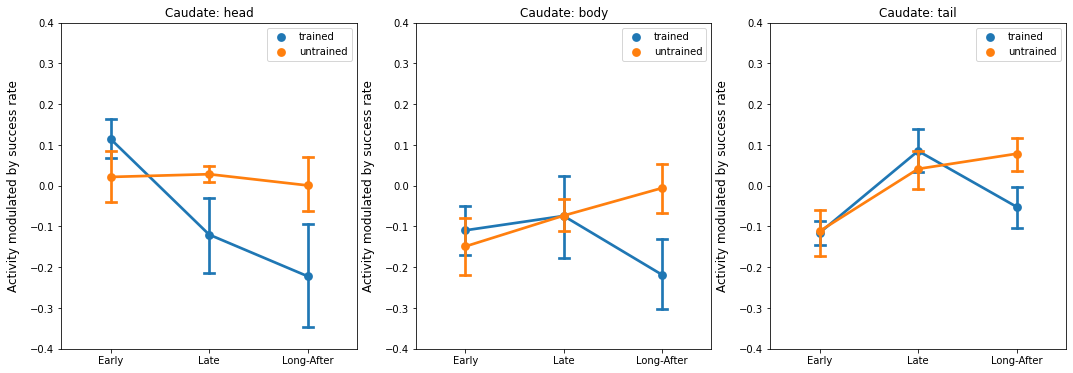

In [117]:
temp = dk.replace({'subj':'GA'},{'subj':'GD'}, regex=True) # regex: regular expression)
temp = temp[temp.subj.isin(df.subj.unique())]
temp = pd.concat([temp,df])

fig, axes = plt.subplots(1,3)
fig.set_size_inches(18, 6)

for i,roi in enumerate(['head','body','tail']):
    ax = sns.pointplot(x='group', y='mean', data=temp[temp.roi==roi],
                       ci=sigma_1*100,      # ci=standard error
                       hue='mapping',
                       capsize=.1,
                       markers='o',
                       ax = axes[i])
    ax.set_ylim(-.4,.4)
    ax.legend(loc='best')
    ax.set_ylabel('Activity modulated by success rate', fontsize=12, labelpad=10)
    ax.set_xlabel(None)
    ax.set_title('Caudate: %s'%roi)
plt.savefig(today+'_GDs_excepted_caudate', dpi=300)

## Plot the data for 14 people in group GD

In [118]:
temp = glob(join(preproc_dir,'GD*'))
subj_list = [a[-4:] for a in temp]

df = pd.DataFrame(columns=['subj','mean','roi','mapping','group'])
for subj in subj_list:
    ## individual roi mask
    temp = subj[0] + 'A' + subj[2:]
    path_roi = join(mask_caudate_fin_dir,'%s_1_caudate_head_resam.nii'%temp)
    roi_head = nilearn.image.load_img(path_roi)
    path_roi = join(mask_caudate_fin_dir,'%s_2_caudate_body_resam.nii'%temp)
    roi_body = nilearn.image.load_img(path_roi)
    path_roi = join(mask_caudate_fin_dir,'%s_3_caudate_tail_resam.nii'%temp)
    roi_tail = nilearn.image.load_img(path_roi)
    
    ## epi (Run 1 to 3)
    path_epi = join(stat_dir,'Reg1_GLM_test','group','statsRWDtime.%s.run1to3.SPMG2.nii.gz'%subj)
    epi = nilearn.image.load_img(path_epi)
    ## caudate head
    roi = roi_head
    size_roi = np.sum(roi_head.get_fdata())
    temp = nilearn.image.math_img("img1*img2", img1=epi, img2=roi)
    mean = np.sum(temp.get_fdata())/size_roi
    df = df.append({'subj':subj,'mean':mean,'roi':'head','mapping':'trained','group':'Long-After'}, ignore_index=True)
    ## caudate body
    roi = roi_body
    size_roi = np.sum(roi_body.get_fdata())
    temp = nilearn.image.math_img("img1*img2", img1=epi, img2=roi)
    mean = np.sum(temp.get_fdata())/size_roi
    df = df.append({'subj':subj,'mean':mean,'roi':'body','mapping':'trained','group':'Long-After'}, ignore_index=True)
    ## caudate tail
    roi = roi_tail
    size_roi = np.sum(roi_tail.get_fdata())
    temp = nilearn.image.math_img("img1*img2", img1=epi, img2=roi)
    mean = np.sum(temp.get_fdata())/size_roi
    df = df.append({'subj':subj,'mean':mean,'roi':'tail','mapping':'trained','group':'Long-After'}, ignore_index=True)
    
    ## epi (Run 4 to 6)
    path_epi = join(stat_dir,'Reg1_GLM_test','group','statsRWDtime.%s.run4to6.SPMG2.nii.gz'%subj)
    epi = nilearn.image.load_img(path_epi)
    ## caudate head
    roi = roi_head
    size_roi = np.sum(roi_head.get_fdata())
    temp = nilearn.image.math_img("img1*img2", img1=epi, img2=roi)
    mean = np.sum(temp.get_fdata())/size_roi
    df = df.append({'subj':subj,'mean':mean,'roi':'head','mapping':'untrained','group':'Long-After'}, ignore_index=True)
    ## caudate body
    roi = roi_body
    size_roi = np.sum(roi_body.get_fdata())
    temp = nilearn.image.math_img("img1*img2", img1=epi, img2=roi)
    mean = np.sum(temp.get_fdata())/size_roi
    df = df.append({'subj':subj,'mean':mean,'roi':'body','mapping':'untrained','group':'Long-After'}, ignore_index=True)
    ## caudate tail
    roi = roi_tail
    size_roi = np.sum(roi_tail.get_fdata())
    temp = nilearn.image.math_img("img1*img2", img1=epi, img2=roi)
    mean = np.sum(temp.get_fdata())/size_roi
    df = df.append({'subj':subj,'mean':mean,'roi':'tail','mapping':'untrained','group':'Long-After'}, ignore_index=True)

df

,subj,mean,roi,mapping,group
0,GD01,-0.222436,head,trained,Long-After
1,GD01,-0.593712,body,trained,Long-After
2,GD01,-0.115031,tail,trained,Long-After
3,GD01,-0.276899,head,untrained,Long-After
4,GD01,-0.341795,body,untrained,Long-After
...,...,...,...,...,...
79,GD44,0.114132,body,trained,Long-After
80,GD44,-0.106895,tail,trained,Long-After
81,GD44,0.351881,head,untrained,Long-After
82,GD44,0.228941,body,untrained,Long-After


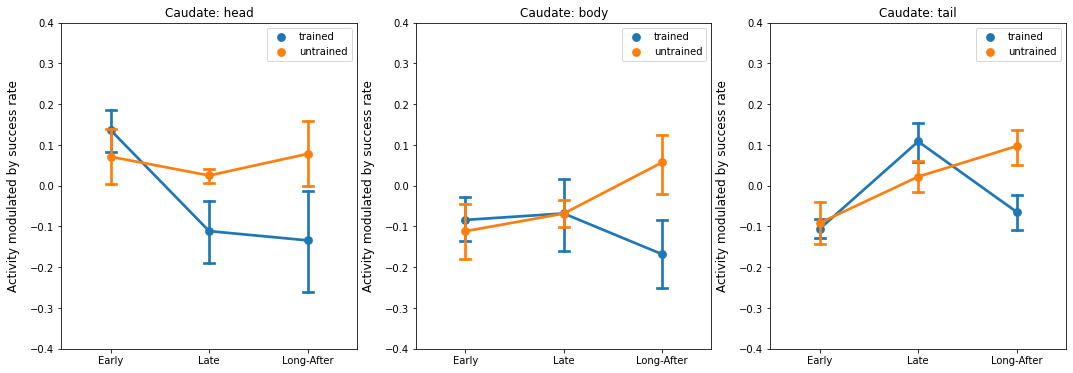

In [121]:
temp = dk.replace({'subj':'GA'},{'subj':'GD'}, regex=True) # regex: regular expression)
temp = temp[temp.subj.isin(df.subj.unique())]
temp = pd.concat([temp,df])

fig, axes = plt.subplots(1,3)
fig.set_size_inches(18, 6)

for i,roi in enumerate(['head','body','tail']):
    ax = sns.pointplot(x='group', y='mean', data=temp[temp.roi==roi],
                       ci=sigma_1*100,      # ci=standard error
                       hue='mapping',
                       capsize=.1,
                       markers='o',
                       ax = axes[i])
    ax.set_ylim(-.4,.4)
    ax.legend(loc='best')
    ax.set_ylabel('Activity modulated by success rate', fontsize=12, labelpad=10)
    ax.set_xlabel(None)
    ax.set_title('Caudate: %s'%roi)
plt.savefig(today+'_GDs_caudate', dpi=300)

# MVPA analysis (GM project)